In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from torchvision import transforms
import torch
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split
import torch.nn as nn

# Using GPU as accelerator

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Train test split

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

source_dir = '/kaggle/input/face-expression-recognition-dataset/images/train'
working_dir = '/kaggle/working'
train_dir = os.path.join(working_dir, 'train')
test_dir = os.path.join(working_dir, 'test')

# Define emotion categories
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Create directories in /kaggle/working
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)
for category in categories:
    os.makedirs(os.path.join(train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(test_dir, category), exist_ok=True)

# Load image file paths and labels
file_paths = []
labels = []

for category in categories:
    category_path = os.path.join(source_dir, category)
    for file_name in os.listdir(category_path):
        file_path = os.path.join(category_path, file_name)
        file_paths.append(file_path)
        labels.append(category)

# Split the data into training and testing sets
train_paths, test_paths, train_labels, test_labels = train_test_split(file_paths, labels, test_size=0.2, stratify=labels, random_state=42)

# Function to copy files to the destination directory
def copy_files(file_paths, labels, dest_dir):
    for file_path, label in zip(file_paths, labels):
        dest_path = os.path.join(dest_dir, label)
        shutil.copy(file_path, dest_path)
print("Copying training files...")
# Copy training files
copy_files(train_paths, train_labels, train_dir)
print('Copying testing files...')
# Copy testing files
copy_files(test_paths, test_labels, test_dir)

print('Data has been split and copied successfully.')


Copying training files...
Copying testing files...
Data has been split and copied successfully.


# Loading the data and creating train test split

In [5]:
# Define transformations for training and evaluation
train_transforms_resnet = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomRotation(degrees=15),    # Randomly rotate the image by up to 15 degrees
    transforms.RandomHorizontalFlip(p=0.5),  # Randomly flip the image horizontally with a probability of 0.5
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Adjust brightness, contrast, saturation, and hue
    transforms.RandomResizedCrop(size=(224), scale=(0.8, 1.0)),  # Randomly crop and resize the image
    transforms.RandomVerticalFlip(p=0.5),    # Randomly flip the image vertically with a probability of 0.5
    transforms.RandomGrayscale(p=0.1),       # Randomly convert the image to grayscale with a probability of 0.1
    transforms.ToTensor(),                    # Convert the image to a PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize the image
])

eval_transforms_resnet = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

path = "/kaggle/working/train"
train_dataset = datasets.ImageFolder(root=path, transform=train_transforms_resnet)
path = "/kaggle/working/test"
test_dataset = datasets.ImageFolder(root=path, transform=eval_transforms_resnet)
# Get the number of classes

path = "/kaggle/input/face-expression-recognition-dataset/images/validation"
val_dataset = datasets.ImageFolder(root=path, transform=eval_transforms_resnet)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)
num_classes = len(train_dataset.classes)

# Size of each data split

In [6]:
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

7066


In [17]:
num_classes

7

# Display a random test image from each split

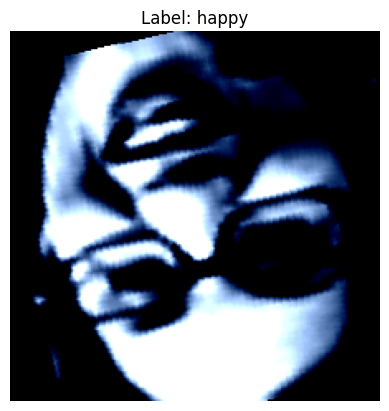

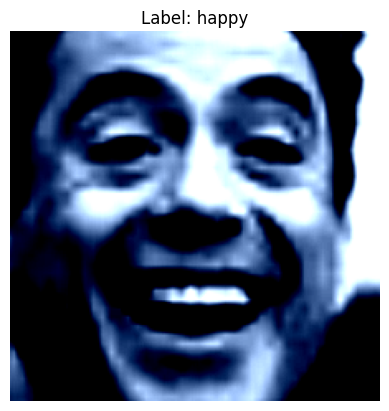

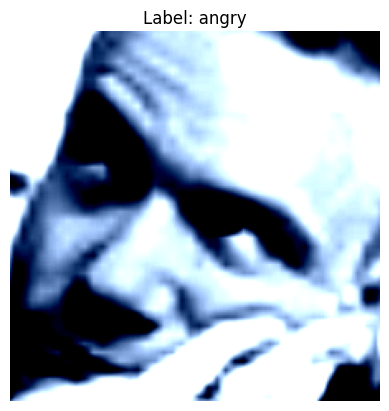

In [7]:
import matplotlib.pyplot as plt
import numpy as np

def display_random_image(dataset, loader, class_names):
    # Get a random batch of data
    images, labels = next(iter(loader))
    index = np.random.randint(len(images))
    image = images[index]
    label = labels[index].item()
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.axis('off')
    plt.title(f'Label: {class_names[label]}')
    plt.show()

class_names = train_dataset.classes
display_random_image(train_dataset, train_loader, class_names)
display_random_image(test_dataset, test_loader, class_names)
display_random_image(val_dataset, val_loader, class_names)

# Using pre-trained Resnet50 CNN model

In [24]:
del resnet

In [25]:
resnet = models.resnet50(pretrained=True)

# Modify the final fully connected layer
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, num_classes)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # If multiple GPUs are available, parallelize the model
    resnet = nn.DataParallel(resnet)

# Move the model to the available device(s)
resnet = resnet.to(device)

Let's use 2 GPUs!


In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=0.0001)

# Training phase

In [27]:
num_epochs_resnet = 10
best_val_loss = float('inf')
best_model_weights = None
for epoch in range(num_epochs_resnet):
    resnet.train()
    total_train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs_resnet = resnet(images)
        loss_resnet = criterion(outputs_resnet, labels)

        loss_resnet.backward()
        optimizer.step()

        total_train_loss += loss_resnet.item() * images.size(0)
    print(f'Epoch {epoch+1}: Train Loss: {total_train_loss / len(train_loader.dataset):.4f}')

    resnet.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs_resnet = resnet(images)
            val_loss = criterion(outputs_resnet, labels)
            total_val_loss += val_loss.item() * images.size(0)
            _, predicted = torch.max(outputs_resnet.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    val_loss_avg = total_val_loss / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss_avg:.4f}, Accuracy: {100 * correct_predictions / total_predictions:.2f}%')
    # Save the best model
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        best_model_weights = resnet.state_dict()
        print(f'Saved best model weights with validation loss: {best_val_loss:.4f}')


Epoch 1: Train Loss: 1.3171
Validation Loss: 1.1324, Accuracy: 58.49%
Saved best model weights with validation loss: 1.1324
Epoch 2: Train Loss: 1.1335
Validation Loss: 1.0310, Accuracy: 61.31%
Saved best model weights with validation loss: 1.0310
Epoch 3: Train Loss: 1.0744
Validation Loss: 1.0124, Accuracy: 61.77%
Saved best model weights with validation loss: 1.0124
Epoch 4: Train Loss: 1.0289
Validation Loss: 1.0063, Accuracy: 62.96%
Saved best model weights with validation loss: 1.0063
Epoch 5: Train Loss: 0.9890
Validation Loss: 1.0148, Accuracy: 62.60%
Epoch 6: Train Loss: 0.9563
Validation Loss: 0.9624, Accuracy: 64.02%
Saved best model weights with validation loss: 0.9624
Epoch 7: Train Loss: 0.9328
Validation Loss: 0.9523, Accuracy: 64.53%
Saved best model weights with validation loss: 0.9523
Epoch 8: Train Loss: 0.9042
Validation Loss: 0.9951, Accuracy: 63.27%
Epoch 9: Train Loss: 0.8811
Validation Loss: 0.9571, Accuracy: 65.17%
Epoch 10: Train Loss: 0.8531
Validation Loss: 

# Train on 5 more epochs

In [28]:
num_epochs_resnet = 5
for epoch in range(num_epochs_resnet):
    resnet.train()
    total_train_loss = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs_resnet = resnet(images)
        loss_resnet = criterion(outputs_resnet, labels)

        loss_resnet.backward()
        optimizer.step()

        total_train_loss += loss_resnet.item() * images.size(0)
    print(f'Epoch {epoch+1}: Train Loss: {total_train_loss / len(train_loader.dataset):.4f}')

    resnet.eval()
    total_val_loss = 0
    correct_predictions = 0
    total_predictions = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs_resnet = resnet(images)
            val_loss = criterion(outputs_resnet, labels)
            total_val_loss += val_loss.item() * images.size(0)
            _, predicted = torch.max(outputs_resnet.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    val_loss_avg = total_val_loss / len(val_loader.dataset)
    print(f'Validation Loss: {val_loss_avg:.4f}, Accuracy: {100 * correct_predictions / total_predictions:.2f}%')
    # Save the best model
    if val_loss_avg < best_val_loss:
        best_val_loss = val_loss_avg
        best_model_weights = resnet.state_dict()
        print(f'Saved best model weights with validation loss: {best_val_loss:.4f}')


Epoch 1: Train Loss: 0.8360
Validation Loss: 0.9535, Accuracy: 65.88%
Epoch 2: Train Loss: 0.8156
Validation Loss: 0.9469, Accuracy: 65.81%
Saved best model weights with validation loss: 0.9469
Epoch 3: Train Loss: 0.7936
Validation Loss: 0.9433, Accuracy: 65.78%
Saved best model weights with validation loss: 0.9433
Epoch 4: Train Loss: 0.7800
Validation Loss: 0.9607, Accuracy: 65.51%
Epoch 5: Train Loss: 0.7501
Validation Loss: 0.9760, Accuracy: 65.03%


In [29]:
resnet.load_state_dict(best_model_weights)

<All keys matched successfully>

# Testing phase

In [30]:
from sklearn.metrics import classification_report

def get_predictions(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

# Save the trained model

In [31]:
save_directory = '/kaggle/working/model'
save_path = os.path.join(save_directory, 'resnet.pth')

if not os.path.exists(save_directory):
    os.makedirs(save_directory)

torch.save(resnet, save_path)

# Downloading the saved model and using it to predict.

In [2]:
import kagglehub

path = kagglehub.model_download("noumannomiah/resnet/pyTorch/resnet_slug")

print("Path to model files:", path)

Attaching model 'noumannomiah/resnet/pyTorch/resnet_slug' to your Kaggle notebook...


Path to model files: /kaggle/input/resnet/pytorch/resnet_slug/1


In [35]:
# save_path = path

resnet_SAVED = torch.load(os.path.join(save_path))
resnet_SAVED = resnet_SAVED.to(device)

In [36]:
categories = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

labels_resnet, preds_resnet = get_predictions(resnet_SAVED, test_loader)

print(classification_report(labels_resnet, preds_resnet,target_names=categories))

              precision    recall  f1-score   support

       angry       0.60      0.55      0.58       799
     disgust       0.60      0.66      0.63        87
        fear       0.48      0.44      0.46       821
       happy       0.91      0.81      0.85      1433
     neutral       0.66      0.58      0.61       996
         sad       0.47      0.68      0.55       988
    surprise       0.74      0.68      0.71       641

    accuracy                           0.64      5765
   macro avg       0.64      0.63      0.63      5765
weighted avg       0.66      0.64      0.65      5765



# Converting to Zip to download model

In [32]:
import os
import shutil
save_directory = '/kaggle/working/model'
if not os.path.exists(save_directory):
    os.makedirs(save_directory)

output_name = '/kaggle/working/resnet_model'
shutil.make_archive(output_name, 'zip', save_directory)

'/kaggle/working/resnet_model.zip'